In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [2]:
AAcode = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Asparagine-13C4': '*Asn',
    'Aspartate': 'Asp',
    'Glutamate': 'Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'}

AAcode_hd = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartate': 'Asp+Asn',
    'Glutamate': 'Gln+Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'
}

NB_code = {'Adenine': 'Ade', 'Guanine': 'Gua', 'Uracil': 'Ura', 'Thymine': 'Thy', 'Cytosine': 'Cyt'}

In [3]:
hd_df = pd.read_excel('on-plate-acid-hydrolysis/output/conc_flat.xlsx')

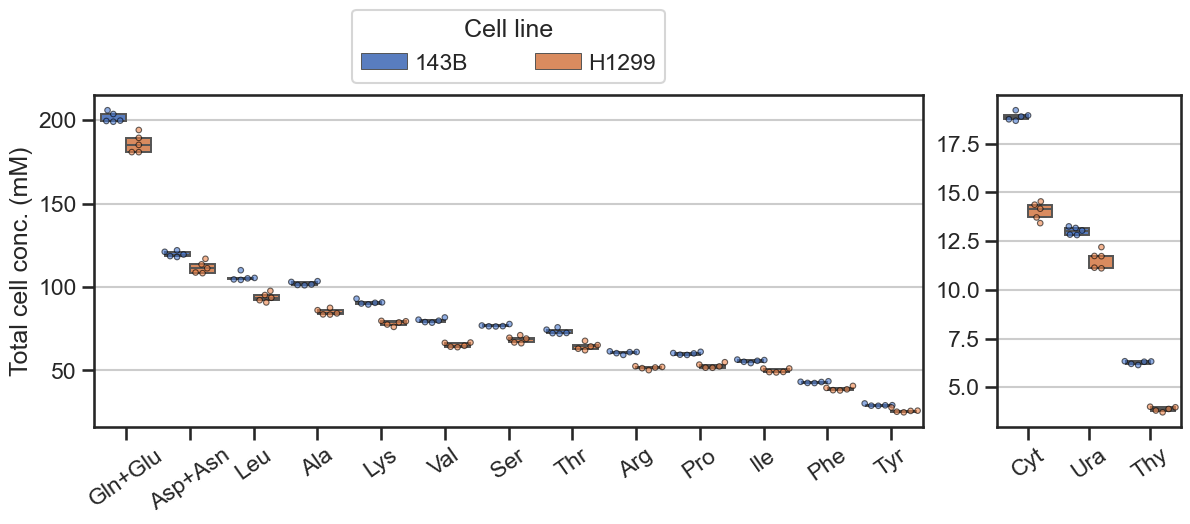

In [4]:
# Create plot grid:
fig = plt.figure(figsize=(13, 5))
gs = GridSpec(8, 10)
ax1 = fig.add_subplot(gs[1:8, 0:7])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8, 7:9])
ax3 = fig.add_subplot(gs[0, 2:5])

# Plot the amino acids:
inclusion_list = set(AAcode_hd.values())
mask = [v in inclusion_list for v in hd_df['Compound'].values]
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=hd_df[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=hd_df[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values()) - set(['Ade', 'Gua'])
mask = [v in inclusion_list for v in hd_df['Compound'].values]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=hd_df[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=hd_df[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True, size=4)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legend_handles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0, 0, 1, 1), loc="lower center", mode="expand", borderaxespad=0, ncol=2, handletextpad=0.3);

# Spacing and print:
#fig.tight_layout(pad=0., w_pad=1.3, h_pad=1.0)
gs.tight_layout(fig, pad=0, w_pad=0.5, h_pad=0.5)
#fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('cell_conc.pdf', bbox_inches='tight')

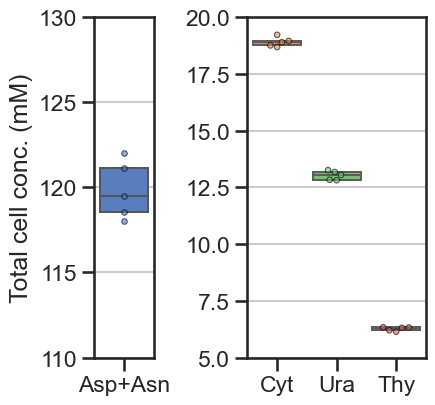

In [5]:
# Create plot grid:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.7, 4.4), gridspec_kw={'width_ratios': [1, 3]})
col_pal = sns.color_palette()

# Plot the amino acids:
inclusion_list = set(['Asp+Asn'])
mask = np.array([v in inclusion_list for v in hd_df['Compound'].values]) & (hd_df['cell_line'] == '143B')
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Compound', data=hd_df[mask], \
                 dodge=True, whis=False, fliersize=False, linewidth=1.4, color=col_pal[0])
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Compound', data=hd_df[mask], edgecolor='black', \
                   linewidth=0.8, alpha=0.6, dodge=True, size=4, color=col_pal[0])
g1.grid(True, axis='y')
g1.set_ylim([110, 130])
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values()) - set(['Ade', 'Gua'])
mask = np.array([v in inclusion_list for v in hd_df['Compound'].values])  & (hd_df['cell_line'] == '143B')
cpal = col_pal[1:4]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Compound', data=hd_df[mask], \
                 dodge=True, whis=False, fliersize=False, linewidth=1.4, palette=cpal)
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Compound', hue='Compound', data=hd_df[mask], edgecolor='black', \
                   linewidth=0.8, alpha=0.6, dodge=False, size=4, palette=cpal, legend=False)
g2.grid(True, axis='y')
g2.set_ylim([5, 20])
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
#g2.set(yticklabels=[]);


# Show/save:
fig.tight_layout()
fig.savefig('cell_conc_143B_Asn_Asp_Pyr.pdf', bbox_inches='tight')

In [6]:
wt_df = pd.read_excel('Asn-consumption-flux_143B/output/influx_flat.xlsx')
wt_df['Cell line'] = 'WT'
wt_label_df = pd.read_excel('Asn-consumption-flux_143B/output/asn_intra_labelling.xlsx')
wt_label_df = wt_label_df.pivot(index='Replicate', columns='Metab', values='Area').reset_index()
wt_label_df['Asn/Asn_13C4'] = wt_label_df['Asn'] / wt_label_df['Asn_13C4']

dko_df = pd.read_excel('AA_influx_143B-GOT-DKO/output/influx_flat.xlsx')
dko_df['Cell line'] = 'DKO'

# df_flux = pd.concat([wt_df, dko_df])

In [7]:
# Calculate Asn fluxes:
mask = (wt_df['Amino acid'].isin(['*Asn', 'Asn'])) & (wt_df['Time'] == 24)
asn_flux_df = wt_df.loc[mask, ['Replicate', 'Amino acid', 'Flux']].reset_index(drop=True).copy()
asn_flux_df = asn_flux_df.pivot(index='Replicate', columns='Amino acid', values='Flux').reset_index().rename_axis(None, axis=1)
asn_flux_df = asn_flux_df.merge(wt_label_df.loc[:, ['Replicate', 'Asn/Asn_13C4']], on='Replicate')
asn_flux_df['Asn_13C4/Asn'] = 1/asn_flux_df['Asn/Asn_13C4']
asn_flux_df['*Asn_percent'] = (asn_flux_df['Asn_13C4/Asn'] / (1 + asn_flux_df['Asn_13C4/Asn'])) * 100
asn_flux_df['Asn_percent'] = (asn_flux_df['Asn/Asn_13C4'] / (1 + asn_flux_df['Asn/Asn_13C4'])) * 100
asn_flux_df['X_dummy'] = 0

asn_flux_df['J_prot'] = asn_flux_df['*Asn'] * (1 + asn_flux_df['Asn/Asn_13C4'])
asn_flux_df['Asn_efflux'] = (asn_flux_df['Asn'] * (1 + 1/asn_flux_df['Asn/Asn_13C4'])) * -1

In [8]:
asn_flux_df

,Replicate,*Asn,Asn,Asn/Asn_13C4,Asn_13C4/Asn,*Asn_percent,Asn_percent,X_dummy,J_prot,Asn_efflux
0,1,1.343054,-0.543034,0.290161,3.446359,77.509690,22.490310,0,1.732757,2.414526
1,2,1.374207,-0.551999,0.306994,3.257391,76.511435,23.488565,0,1.796080,2.350077
2,3,1.219416,-0.565914,0.294400,3.396737,77.255858,22.744142,0,1.578413,2.488174
3,4,1.076012,-0.562474,0.300407,3.328821,76.899022,23.100978,0,1.399254,2.434850
4,5,1.160893,-0.554229,0.300318,3.329807,76.904281,23.095719,0,1.509530,2.399703
5,6,1.229171,-0.555091,0.297054,3.366392,77.097798,22.902202,0,1.594301,2.423747


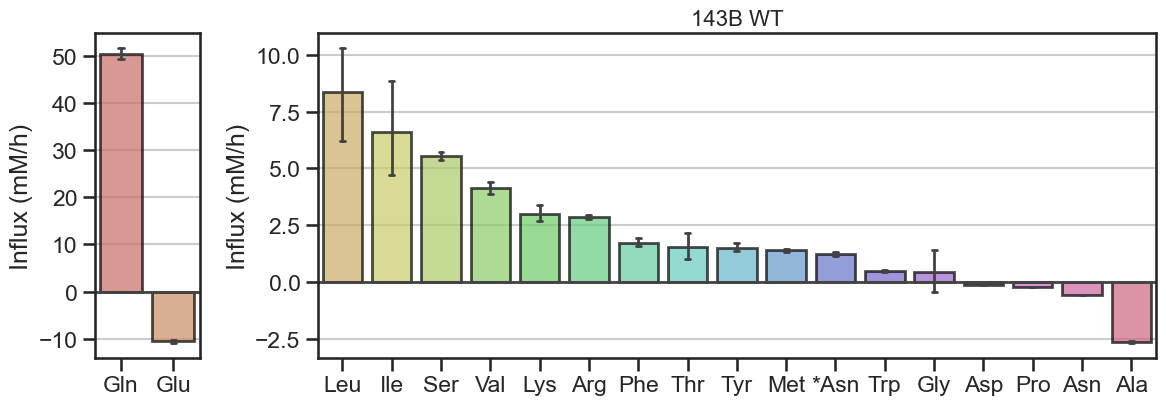

In [9]:
### Plot the WT influx, only 24 h sampling time ###
col_pal = sns.color_palette("hls", 19)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.4), gridspec_kw={'width_ratios': [1, 8]})

# Small plot for Gln/Glu:
mask = (wt_df['Amino acid'].isin(['Gln', 'Glu'])) & (wt_df['Time'] == 24)
order = wt_df[mask].groupby('Amino acid').mean(numeric_only=True)['Flux'].sort_values(ascending=False).index.values
cpal = col_pal[0:2]
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", data=wt_df[mask], capsize=.1, errwidth=2, \
                 edgecolor='black', linewidth=2, alpha=0.7, order=order, palette=cpal)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Influx (mM/h)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot the all other AAs:
mask2 = (wt_df['Amino acid'].isin(list(AAcode.values()))) & (wt_df['Time'] == 24)
order = wt_df[~mask&mask2].groupby('Amino acid').mean(numeric_only=True)['Flux'].sort_values(ascending=False).index.values
cpal = col_pal[2:]
g2 = sns.barplot(ax=ax2, x="Amino acid", y="Flux", data=wt_df[~mask&mask2], capsize=.1, errwidth=2, \
                 edgecolor='black', linewidth=2, alpha=0.7, order=order, palette=cpal)
ax2.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g2.grid(True, axis='y')
g2.set_ylabel('Influx (mM/h)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
#g2.set_ylim([-1.4, 5.6])
#g2.yaxis.set_major_locator(ticker.MultipleLocator(1))
g2.set_title('143B WT', size=16)
#fig.suptitle('143B WT', size=16)

# Show/save:
fig.tight_layout()
fig.savefig('WT_influx.pdf', bbox_inches='tight')

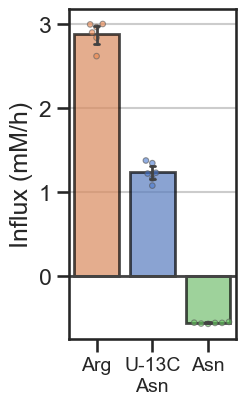

In [10]:
### Plot the WT influx ###
col_pal = sns.color_palette()

wt_df_rn = wt_df.replace({'*Asn': 'U-13C\nAsn'})


fig, ax1 = plt.subplots(1, 1, figsize=(2.8, 4.4))

# Small plot for Gln/Glu:
cpal = [col_pal[1], col_pal[0], col_pal[2]]
mask = (wt_df_rn['Amino acid'].isin(['Arg', 'U-13C\nAsn', 'Asn'])) & (wt_df_rn['Time'] == 24)
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", data=wt_df_rn[mask], capsize=.1, errwidth=2, \
                 edgecolor='black', linewidth=2, alpha=0.7, palette=cpal)

g1 = sns.swarmplot(ax=ax1, x="Amino acid", y="Flux", hue="Amino acid", data=wt_df_rn[mask], \
                   linewidth=0.8, alpha=0.6, dodge=False, size=4, palette=cpal, legend=False, zorder=1)

ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Influx (mM/h)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=0, size=14) #, rotation_mode='anchor', ha='right');

# Show/save:
fig.tight_layout()
fig.savefig('WT_influx_Arg_Asn.pdf', bbox_inches='tight')

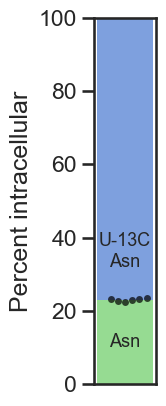

In [11]:
col_pal = sns.color_palette()
cpal = [col_pal[2], col_pal[0]]


fig, ax1 = plt.subplots(1, 1, figsize=(2, 4.4))

bar_values = asn_flux_df.mean()[['Asn_percent', '*Asn_percent']].values


g1 = sns.swarmplot(ax=ax1, x="X_dummy", y="Asn_percent", data=asn_flux_df, \
                   alpha=0.7, color='black')


p = ax1.bar(0, height=bar_values[0], color=cpal[0], alpha=0.7, linewidth=0)
p = ax1.bar(0, height=bar_values[1], color=cpal[1], alpha=0.7, bottom=bar_values[0], linewidth=0)

ax1.set_ylim([0, 100])
ax1.set_xlabel('');
ax1.set_ylabel('Percent intracellular');
ax1.text(0, 10, 'Asn', ha='center', size=13)
ax1.text(0, 32, 'U-13C\nAsn', ha='center', size=13)
ax1.set_xticklabels('')
ax1.xaxis.set_major_locator(plt.NullLocator())


# Show/save:
fig.tight_layout()
fig.savefig('WT_Asn_label_ratio.pdf', bbox_inches='tight')

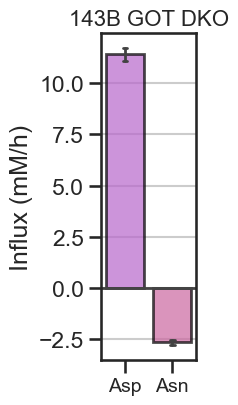

In [12]:
### Plot the DKO influx, averaging over the sampling times ###
col_pal = sns.color_palette("hls", 19)

fig, ax1 = plt.subplots(1, 1, figsize=(2.4, 4.4))

mask = (dko_df['Amino acid'].isin(['Asp', 'Asn']))
cpal = [col_pal[15], col_pal[17]]
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", data=dko_df[mask], capsize=.1, errwidth=2, \
                 edgecolor='black', linewidth=2, alpha=0.7, palette=cpal)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Influx (mM/h)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=0, size=14) #, rotation_mode='anchor', ha='right');
g1.set_title('143B GOT DKO', size=16)

# Show/save:
fig.tight_layout()
fig.savefig('DKO_influx_Asp_Asn.pdf', bbox_inches='tight')

In [22]:
prlfr/24 * np.log(2)

0.03691656312123261

In [13]:
# Extract all aspartate fluxes:
asp_fluxes = asn_flux_df.loc[:, ['Replicate', 'J_prot', 'Asn_efflux']]\
  .rename(columns={'J_prot': 'Protein (Asn)', 'Asn_efflux': 'Efflux (Asn)*'})\
  .melt(id_vars=['Replicate'], var_name='Type', value_name='Flux').copy()

In [14]:
# Calculate aspartate consumption flux:
mask = (hd_df['Compound'] == 'Asp+Asn') & (hd_df['cell_line'] == '143B')
asp_acc = hd_df[mask].copy()

prlfr = 1.278224221 # doublings per day for 143B (from Asn consumption assay)
asp_acc['Flux'] = prlfr/24 * np.log(2) * asp_acc['Concentration']
asp_acc['Protein (Asp)'] = asp_acc['Flux'] - asn_flux_df.mean()['J_prot']
asp_acc = asp_acc.rename(columns={'well': 'Replicate'})
asp_prot = asp_acc.loc[:, ['Replicate', 'Protein (Asp)']].melt(id_vars=['Replicate'], var_name='Type', value_name='Flux').copy()

In [15]:
# Calculate pyrimidine/purine flux 
inclusion_list = set(NB_code.values()) - set(['Ade', 'Gua'])
mask = np.array([v in inclusion_list for v in hd_df['Compound'].values])  & (hd_df['cell_line'] == '143B')
pyr_acc = hd_df[mask].pivot(index='well', columns='Compound', values='Concentration').reset_index()
pyr_acc['Pyr_conc'] = pyr_acc.loc[:, ['Cyt', 'Thy', 'Ura']].sum(axis=1)

pyr_acc['Pyrimidines'] = prlfr/24 * np.log(2) * pyr_acc['Pyr_conc']
pyr_acc = pyr_acc.rename(columns={'well': 'Replicate'})
pyr = pyr_acc.loc[:, ['Replicate', 'Pyrimidines']].melt(id_vars=['Replicate'], var_name='Type', value_name='Flux').copy()

pur = pyr.loc[0:0, :].copy()
pur['Type'] = 'Purines'
pur['Flux'] = 1.5 * pyr['Flux'].mean()

In [16]:
# Get Arginine fluxes:
mask = (wt_df['Amino acid'] == 'Arg') & (wt_df['Time'] == 24)
arg_prot = wt_df[mask].copy()
arg_prot['Type'] = 'Protein (Arg)'
arg_prot = arg_prot.loc[:, ['Replicate', 'Type', 'Flux']].copy()

In [17]:
asp_fluxes = pd.concat([asp_fluxes, asp_prot, pyr, pur, arg_prot]).reset_index(drop=True)
asp_fluxes['Nitrogen donation'] = asp_fluxes['Type'].isin(['Protein (Arg)', 'Purines'])

In [18]:
asp_fluxes.head(3)

,Replicate,Type,Flux,Nitrogen donation
0,1,Protein (Asn),1.732757,False
1,2,Protein (Asn),1.796080,False
2,3,Protein (Asn),1.578413,False


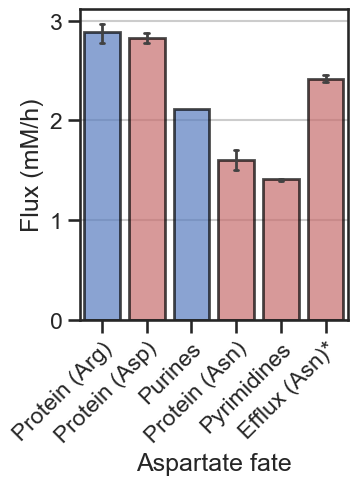

In [19]:
pal = list(sns.color_palette())
order = ['Protein (Arg)', 'Protein (Asp)', 'Purines', 'Protein (Asn)', 'Pyrimidines', 'Efflux (Asn)*']
col = [pal[0], pal[3], pal[0], pal[3], pal[3], pal[3]]

fig, ax1 = plt.subplots(1, 1, figsize=(4, 5.2))

#g1 = sns.barplot(ax=ax1, x="Fate", y="Flux", hue="Asn efflux", data=asp_fluxes, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
#pal = list(sns.color_palette())
#pal[5] = pal[7]
g1 = sns.barplot(ax=ax1, x="Type", y="Flux", data=asp_fluxes, capsize=.1, \
                 errwidth=2, edgecolor='black', linewidth=2, alpha=0.7, order=order, palette=col)

g1.grid(True, axis='y')
g1.set_ylabel('Flux (mM/h)');
g1.set_xlabel('Aspartate fate');
g1.set_xticklabels(g1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor');

fig.tight_layout()
fig.savefig('asp_fate3.pdf')

In [20]:
asp_fluxes_tab = asp_fluxes.pivot(index='Replicate', columns='Type', values='Flux').reset_index()

In [21]:
asp_fluxes_tab.mean()[['Efflux (Asn)*', 'Protein (Asn)', 'Protein (Asp)', 'Pyrimidines', 'Purines']].sum()

10.365969039582566

In [2]:
plot_df = pd.read_excel('asp_fate_plotting.xlsx')
plot_df

,Fate,Asn efflux,Percent
0,Protein (Asp),Yes,27.935361
1,Efflux (Asn),Yes,25.992724
2,Protein (Asn),Yes,17.268010
3,Pyrimidines,Yes,14.401952
4,Purines,Yes,14.401952
5,Protein (Asp),No,37.746777
6,Efflux (Asn),No,0.000000
7,Protein (Asn),No,23.332855
8,Pyrimidines,No,19.460184
9,Purines,No,19.460184


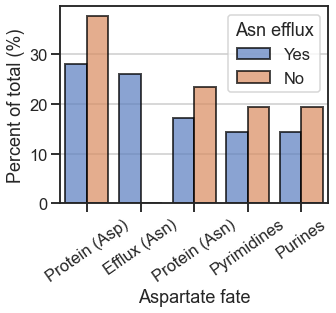

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4.7))

g1 = sns.barplot(ax=ax1, x="Fate", y="Percent", hue="Asn efflux", data=plot_df, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)

g1.grid(True, axis='y')
g1.set_ylabel('Percent of total (%)');
g1.set_xlabel('Aspartate fate');
g1.set_xticklabels(g1.get_xticklabels(), rotation=35);

fig.tight_layout()
fig.savefig('asp_fate.pdf')

In [4]:
plot_df = pd.read_excel('asp_fate2_plotting.xlsx')
plot_df

,Fate,Flux,Percent,Nitrogen donation
0,Protein (Arg),2.881181,22.506423,True
1,Protein (Asp),2.585267,20.194886,False
2,Purines,1.999235,15.617077,True
3,Protein (Asn),1.598061,12.483300,False
4,Pyrimidines,1.332823,10.411384,False
5,Efflux (Asn)*,2.405026,18.786930,False


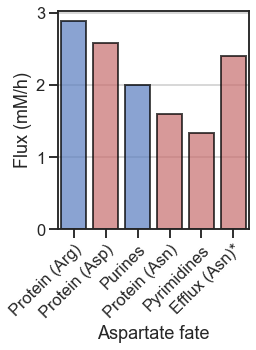

In [7]:
pal = list(sns.color_palette())
new_pal = [pal[0] if nd else pal[3] for nd in plot_df['Nitrogen donation']]
#new_pal[-1] = pal[7]


fig, ax1 = plt.subplots(1, 1, figsize=(4, 5.2))

#g1 = sns.barplot(ax=ax1, x="Fate", y="Flux", hue="Asn efflux", data=plot_df, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
#pal = list(sns.color_palette())
#pal[5] = pal[7]
g1 = sns.barplot(ax=ax1, x="Fate", y="Flux", data=plot_df, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7, palette=new_pal)

g1.grid(True, axis='y')
g1.set_ylabel('Flux (mM/h)');
g1.set_xlabel('Aspartate fate');
g1.set_xticklabels(g1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor');

fig.tight_layout()
fig.savefig('asp_fate2.pdf')